<h3>Multi-scale Topographic Classification A Machine Learning Approach Support Vector Machines II<h3>

In this notebook we experiment with using binary supervised classifier as a means to differentiate and map topographic landscapes. In particular, for this preliminary work, we attempt to model the U.S. Mid-Atlantic Coastal Plain, distinguishing it from its upland piedmont counterpart. The binary classifier selected is the support vector machine (SVM). SVMs are robust, high-dimensional, non-linear classifiers. The question is, are they sufficiently robust, and sensitive, to be able to reliably and consistently identifdy the boundary betweeen the upland piedmont and coastal plain provinces, a boundary that is subtle at best, even to the human eye? 

The overarching assumption here is that the coastal plain province, and by extension coastal plains in general, present topographic characteristics that differ geomorphically/geomorphometrically with the adjacent upland. Further, these differientiating characteristics can measured and used to build  classification model that distinguishes in some meaningful way, present a less topographically varied (i.e. rough) character than do the interior uplands [onto which the coastal plains abutt). Further, we assume that, in the presence of true assumptions, we can further identify, quantitatively model, and go on to map this difference and the two provinces--reliably. Repeatably. Maybe even globally!


**Load Requisite Modules, Libraries, and Magics:**

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

**Load the [labeled] sample observation data**

NOTE: the labeled data has class labels assigned (1 for coastal plain and -1 for not coastal plain). This was be done in QGIS (because I couldn't find a command in GRASS to do it directly).

**NOTE2: THESE DATA ARE SLOPE CONSTRAINED: ALL SLOPES <= 0.69 DEGREES**

In [2]:
datapath='/Users/paulp/GoogleDrive/projects/CoastalPlains/data/'
file='CoastalPlainTrainingPts.csv'

# temp: train_test_10k_pts

### load the training points to a pandas dataframe, then extract a random
### sample subset for testing. The entire 4327 observation data set will demaind a lot of
### computer resources so it would be best to get things checked initially out on
### a smaller, less computationally demanding sample set...
dfsvm=pd.read_csv(datapath+file)
#dfsvm2k = dfsvm.sample(n=2500, replace=False)

# build the standardized X features and y target arrays:
scaler = StandardScaler()
X=scaler.fit_transform(np.array(dfsvm[['z','distance']]) )
y=np.array(dfsvm['label']) 
print(np.shape(y), np.shape(X))

(4327,) (4327, 2)


<h3>Applying the Support Vector Machine</h3>

A new dataset, one based on the originals found above in dataframes df and df2, was generated which replaced the 'cluster' with the attribute 'label'. The label attribute was populated so as to convert the original sample points in to one suitable to serve as a training and testing data set for the coming SVM experiments.  

Label is populated as either = 1 (is classified as falling inside the coastal plain) or -1 (is classified as NOT falling in the coastal plain). These assignments were conducted in QGIS using geologic data downloaded from the USGS which permitted mapping a 'fall-line' that would delineate the upland boundary of the U.S. Altantic Coastal Plain.

Let's proceed...

**Load the new sample data set and partition into a predictor X matrix and y response array...**

In [4]:
# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.scatter(X[:,0], X[:,1], s=42, c=y, cmap=mpl.cm.Paired)
    
    # Support vectors indicated in plot by vertical lines
    #sv = svc.support_vectors_
    #plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.42)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

First, we'll plot the observation sample, labeling the points based on their respective designations as either falling in the coastal plain or not (the y array) to see if the data might be linearly seperable. Note that is highly unlikely, but it's always a good idea to have a look at the data. Note too that since we are extracting a random subsample from the full data set (at least for now) the point pattern seen in the plot will vary a little, or a lot, with each run of the loader cell, above...

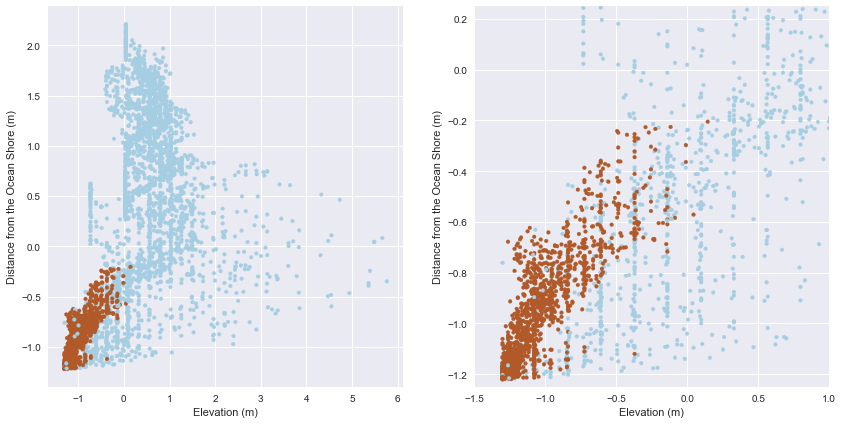

In [92]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14,7)) 

ax1.scatter(X[:,0],X[:,1], c=y, s=14, cmap=mpl.cm.Paired)
ax1.set_xlabel('Elevation (m)')
ax1.set_ylabel('Distance from the Ocean Shore (m)')

ax2.scatter(X[:,0],X[:,1], c=y, s=14, cmap=mpl.cm.Paired)
ax2.set_xlim(-1.5, 1)
ax2.set_ylim(-1.25, 0.25)
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Distance from the Ocean Shore (m)')

There is nothing here in the plot to suggest that a linear partition will cleanly and completely separate the coastal plain (tan-colored dots) from the upland (blue-colored dots). Still, we can see that the coastal plain group (y = 1) are, as would be expected, clustered in the plot's lower-left corner (lower elevations and close to coast). Further, there is incomplete overlap between coastal plain and upland observations (blue dots). This suggests that, while a nice, neat linear, error free classifier isn't in the cards, a useful SVM model that can partition the two regions may well be possible.

Let's do some experiments to see if we can fit just such a reasonable Support Vector Machines model...

**Create training and testing data subsets**

The training data is used to fit the Support Vector Machine (SVM) model (the SVM classifer is actually fit to the training data). We do initial testing and tuning of the model via cross-validation (coming next) and then "test" the model against the test data subset for generalization--its ability to predict using datasets of unknown classification.

In [21]:

holdout=0.3
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=holdout, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=holdout, random_state=42)

print('Total Sample Observations:', len(X))
print('Observations in training set:', len(Xtrain))
print('Observations in test set:', len(Xtest))

Total Sample Observations: 4327
Observations in training set: 2119
Observations in test set: 1299


**Cross-validation**

We do a cross-validation in order to determine which of the available non-linear kernels (polynomial and radial basis) along with the optimal parameters for that kernel, best 'fits' or models the training data. The training data consists of a set of random sample points distributed across the study area. Those sample points in the study area that fall within the coastal plain are encoded: 1, while those that fall outside the coastal plain are encoded: 0. 

To do the cross-validation we will use sklearn's GridSearchCV. GridSearchCV does a KFold cross-validation (here we set the number of folds to 10), running the cv using all combinations of the parameters that we define. For those parameters, we will test two kernels: one polynomial the other a radial basis function (rbf). Both will be tested and optimized using a set of kernel params to identify both the kernel and parameters that yield the highest goodness-of-fit score. Those results will then be used to train and test the SVM with our sample observation dataset. We report the GRIDSearch results using the .best\_params\_ method.

In [10]:
%%time
### note that this cross-validation op. takes a really long time to run.
### So long, in fact, that, after 24+ hours, I still had not reached 
### an end.

parameters=[{'kernel':['poly', 'rbf'], 'C':[0.1, 1, 5, 10], 'degree':[2,3,4], 'gamma':[1,2,3]}]
sv=svm.SVC()
cv = GridSearchCV(estimator=sv, param_grid=parameters, cv=10, scoring='accuracy')
cv.fit(Xtrain,ytrain)

CPU times: user 9min 8s, sys: 2 s, total: 9min 10s
Wall time: 9min 27s


In [13]:
### retrieve and print the GridSearch cross-validation parameter results:
cv.best_params_

{'C': 5, 'degree': 2, 'gamma': 2, 'kernel': 'rbf'}

In [126]:
cv.grid_scores_

/Applications/miniconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.84346, std: 0.02068, params: {'C': 0.1, 'gamma': 1, 'kernel': 'poly', 'degree': 2},
 mean: 0.93263, std: 0.01836, params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'degree': 2},
 mean: 0.85370, std: 0.02421, params: {'C': 0.1, 'gamma': 2, 'kernel': 'poly', 'degree': 2},
 mean: 0.93824, std: 0.01744, params: {'C': 0.1, 'gamma': 2, 'kernel': 'rbf', 'degree': 2},
 mean: 0.85469, std: 0.02361, params: {'C': 0.1, 'gamma': 3, 'kernel': 'poly', 'degree': 2},
 mean: 0.94089, std: 0.01685, params: {'C': 0.1, 'gamma': 3, 'kernel': 'rbf', 'degree': 2},
 mean: 0.91017, std: 0.01590, params: {'C': 0.1, 'gamma': 1, 'kernel': 'poly', 'degree': 3},
 mean: 0.93263, std: 0.01836, params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'degree': 3},
 mean: 0.91017, std: 0.01561, params: {'C': 0.1, 'gamma': 2, 'kernel': 'poly', 'degree': 3},
 mean: 0.93824, std: 0.01744, params: {'C': 0.1, 'gamma': 2, 'kernel': 'rbf', 'degree': 3},
 mean: 0.91083, std: 0.01561, params: {'C': 0.1, 'gamma': 3, 'kernel': 'pol

**Generate (learn) an SVM model and plot result**

Using the best estimators from the GridSearch cross-validation build a new (optimized) SVM and plot the resulting clasification regions and member observations.

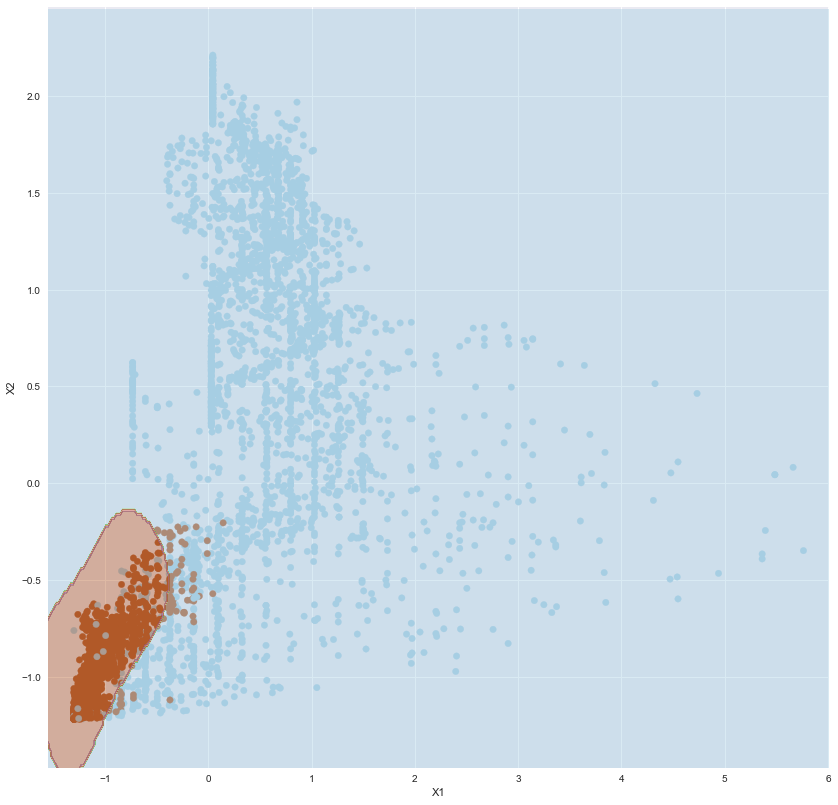

Number of support vectors:  411
CPU times: user 2.19 s, sys: 19.8 ms, total: 2.21 s
Wall time: 2.25 s


In [14]:
%%time
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(14,14))
sv=svm.SVC(C=5, kernel='rbf', gamma=2, degree=2).fit(Xtrain,ytrain)

plot_svc(sv, X, y)

**Scoring and Goodness of Fit**

In [16]:
%%time
splits=10
kf = KFold(n_splits=splits)
scr = [sv.fit(X[train], y[train]).score(X[test], y[test]) for train, test in kf.split(X)] 
print(scr)
print('Average score (goodness of fit):', sum(scr)/splits)
print()
pm = cross_val_score(sv, X, y, cv=kf, scoring='precision_macro')
print(pm)
print('Average score (Precision Macro goodness of fit):', sum(pm)/splits)
print()
# create a confusion matrix to get a count of the number of observations correctly classified
# and the number NOT correctly classified:
#print(confusion_matrix(ytest,sv.predict(Xtest) ))
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(ytest,sv.predict(Xtest)),index=sv.classes_, columns=sv.classes_  )) 
print()
print(cv.best_estimator_.score(Xtest, ytest).round(3))
print()
print('Geometric Mean:', (408/429 * 408/448)**0.5 )
print( )

[0.8314087759815243, 0.91454965357967666, 0.94919168591224024, 0.97921478060046185, 0.9838337182448037, 0.93995381062355654, 0.89376443418013862, 0.90740740740740744, 0.78703703703703709, 0.96527777777777779]
Average score (goodness of fit): 0.915163908134

[ 0.5         0.5         0.5         0.87142857  0.98105139  0.91644082
  0.8903312   0.90790384  0.71764706  0.49058824]
Average score (Precision Macro goodness of fit): 0.727539110629

Confusion Matrix:
     -1    1
-1  830   40
 1   21  408

0.953

Geometric Mean: 0.9306631324673101

CPU times: user 2.74 s, sys: 39.9 ms, total: 2.78 s
Wall time: 2.81 s


408 of 448, or 91% of coastal plain sample points correctly assigned

830 of 851, or 98% of upland sample points correctly assigned

Not too bad, really...

find a 'fall-line' layer, or digitize one, if necessary, and then:
    
- sample elevations along the line
- plot these elevations against the distance to shore / elevation plot, seen above

Q: What is a coast? How can we define it geomorphically? Geomorphometrically?

**Prelim. Title:** Defining the Geomorphometric Coastal Plain: A Machine Learning Approach

What characteristics are important and which of these can be used to define the a 'the coast' as a unique geomorphic entity? 

Elevations
Slopes

If the U.S. East Coast can be considered an archetype, (for model training), can we use it to identify 'coasts' or 'coastal plains' elsewhere in the world? Dunno.